# Plotting Pandapower Networks

This tutorial shows you how to plot pandapower networks. 

We use matplotlib collections to plot the stations or lines in the network. There are different types of elements in matplotlib, like lines, circles, rectangles etc. These elements are bundled into collections, where one objects holds many elements of the same type (see matplotlib documentation: http://matplotlib.org/api/collections_api.html).

The plotting module provides several functions that create collections from pandapower networks. In this interactive tutorial, we show you how to use these functions to plot networks.

In [3]:
import matplotlib.pyplot as plt
import os
import pandapower as pp
import pandapower.plotting as plot
import pandapower.networks as nw
try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]
%matplotlib inline

## Simple Plotting

First, we plot only the lines and buses of an example network. This is done by creating a line collection for all lines and a bus collection for all buses. We then plot both collections with the draw_collections function:

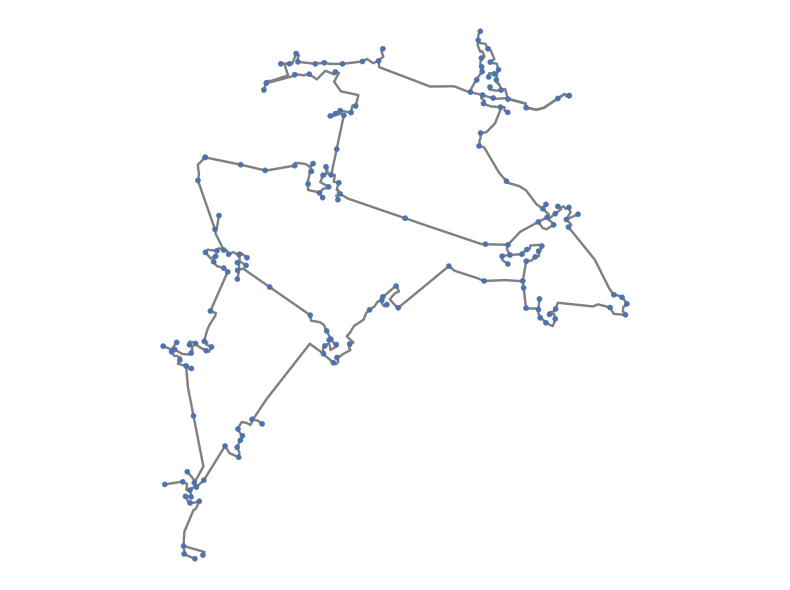

In [7]:
net = nw.mv_oberrhein()
lc = plot.create_line_collection(net, net.line.index, color="grey", zorder=1) #create lines
bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=2) #create buses
plot.draw_collections([lc, bc], figsize=(8,6)) #plot lines and buses

## Highlighting

Specific lines or buses can be highlighted by creating extra line collections in different colors.

In this example, we plot lines that are longer than 2 km green and buses with a voltage below 0.98 pu red.

First, we create a line collection for all lines in grey and a line collection for only the long lines in green:

In [8]:
net = nw.mv_oberrhein()
long_lines = net.line[net.line.length_km > 2.].index
lc = plot.create_line_collection(net, net.line.index, color="grey", zorder=1)
lcl = plot.create_line_collection(net, long_lines, color="g", zorder=2)

Notice that the zorder is higher for the long line collection. This ensures that the red line collection is plotted over the grey line collection.

We then conduct a loadflow and create bus collections in the same way:

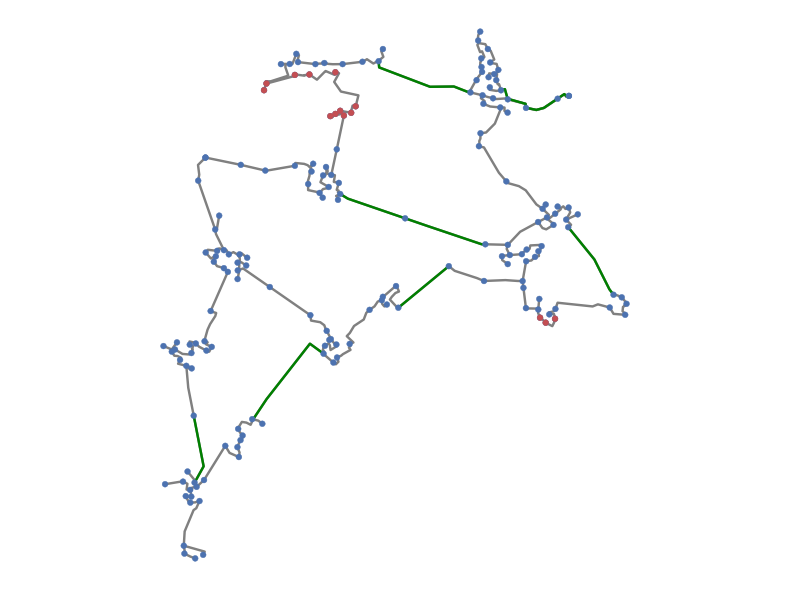

In [9]:
pp.runpp(net)
high_voltage_buses = net.res_bus[net.res_bus.vm_pu < 0.98].index
bc = plot.create_bus_collection(net, net.bus.index, size=90, color=colors[0], zorder=10)
bch = plot.create_bus_collection(net, high_voltage_buses, size=90, color=colors[2], zorder=11)
plot.draw_collections([lc, lcl, bc, bch], figsize=(8,6))

Another way to highlight something is to use a different shape using the patch_type argument of the create_bus collection. You can for example mark the slack bus with a rectangle shape like this:

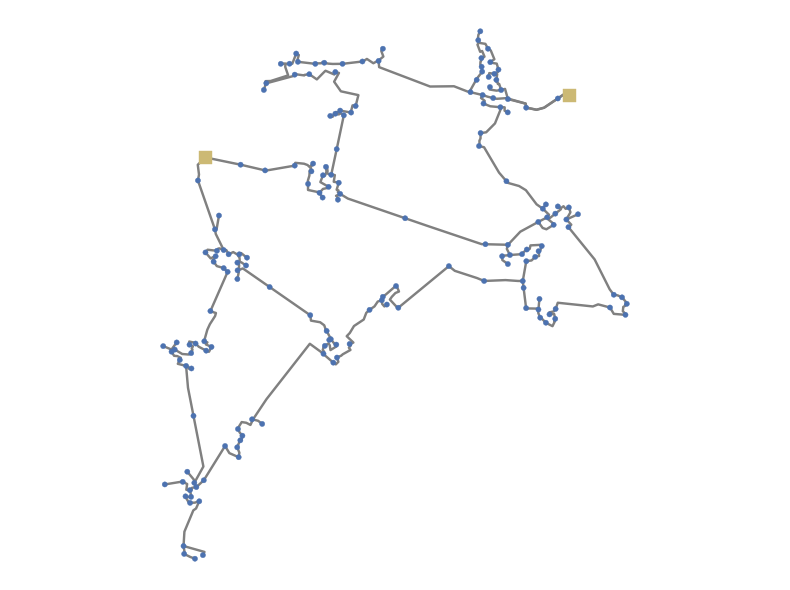

In [12]:
net = nw.mv_oberrhein()
lc = plot.create_line_collection(net, net.line.index, color="grey", zorder=1) #create lines
bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=2) #create buses
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200, color=colors[4], zorder=11)
plot.draw_collections([lc, bc, sc], figsize=(8,6)) #plot lines and buses

## Highlighting with the Topology Package

Combining the [topology package](topology.ipynb) with the plotting package allows highlighting of structural features of the network. For example, we can highlight all buses closer than 5 km to a transformer station:

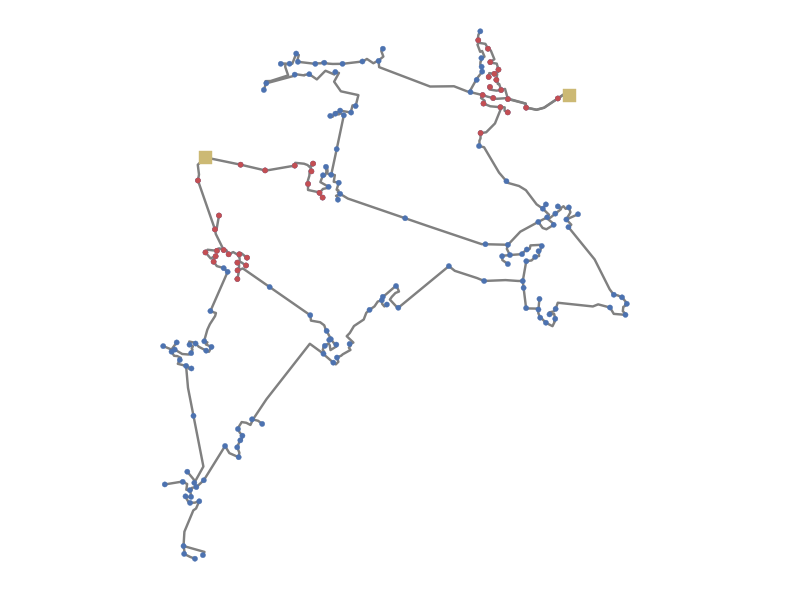

In [14]:
net = nw.mv_oberrhein()
close_buses = set()
for slack in net.ext_grid.bus:
    d = pp.topology.calc_distance_to_bus(net, slack)
    close_buses |= set(d[d < 5].index)

bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=1)
bch = plot.create_bus_collection(net, close_buses, size=80, color=colors[2], zorder=2)
lc = plot.create_line_collection(net, net.line.index, zorder=1, color="grey")
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200, color=colors[4], zorder=11)
plot.draw_collections([lc, bc, bch, sc], figsize=(8,6))

Or to highlight the radiality of the network, plot the seperate feeders in different colors:

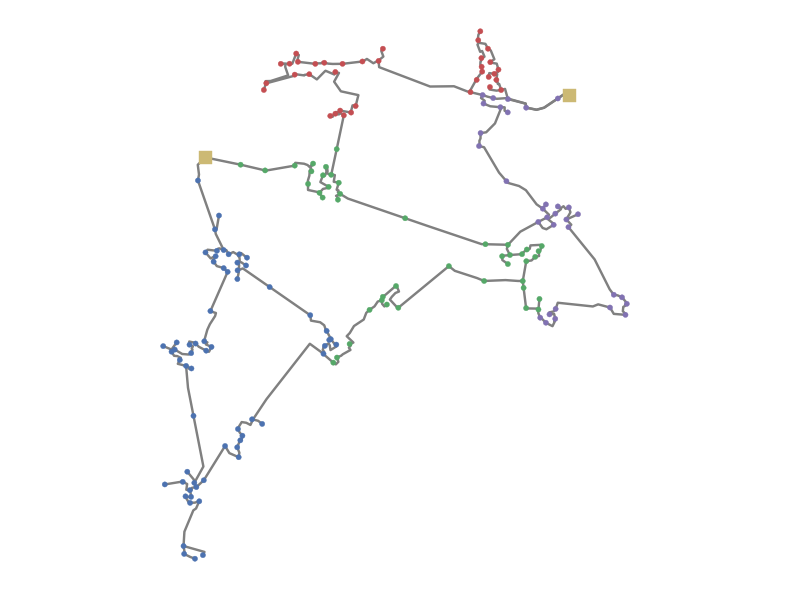

In [16]:
net = nw.mv_oberrhein()
mg = pp.topology.create_nxgraph(net, nogobuses=set(net.trafo.lv_bus.values) | set(net.trafo.hv_bus.values))
collections = []
for color, area in zip(colors, pp.topology.connected_components(mg)):
    collections.append(plot.create_bus_collection(net, area, size=80, color=color, zorder=2))
collections.append(plot.create_line_collection(net, net.line.index, zorder=1, color="grey"))
collections.append(plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200,
                                              color=colors[4], zorder=11))
plot.draw_collections(collections, figsize=(8,6))

## Colormaps

You can use colormaps to colour your network plots in order to get a quick and simple overview of line loadings and bus voltages. The plotting module provides functions to easily modify your bus and line collections. It also provides colourbars to match the colourcodes to the according numerical values.

### Continous Colormaps

First, we load the network and run a loadflow to retrieve results:

In [4]:
net = nw.mv_oberrhein()
pp.runpp(net)

The pandapower plotting package contains convenience functions to create common colorbars and norms. We use the cmap_continous function to get a linear colormap with color centers at 0%, yellow at 50% and red at 60% line loading:

In [5]:
cmap_list=[(20, "green"), (50, "yellow"), (60, "red")]
cmap, norm = plot.cmap_continous(cmap_list)

The colormap and norm are now passend to the create_bus_collection function and the collection is plotted with draw_collections:

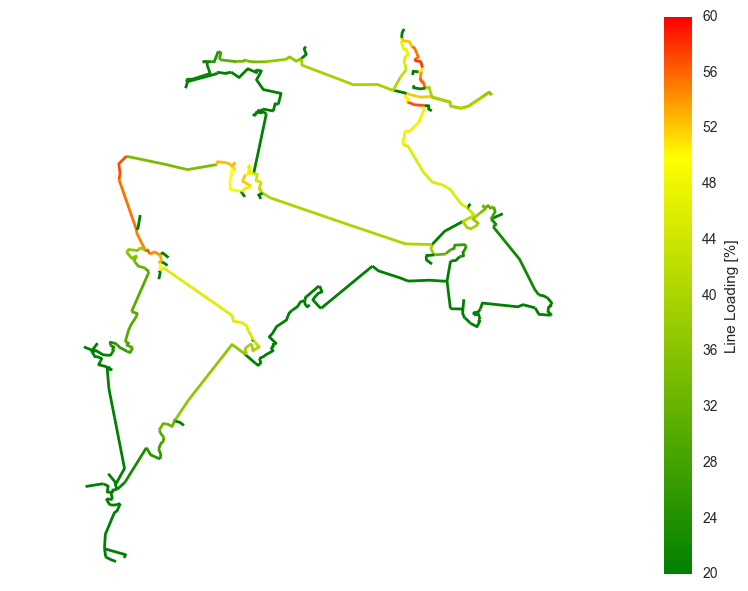

In [6]:
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2)
plot.draw_collections([lc], figsize=(8,6))

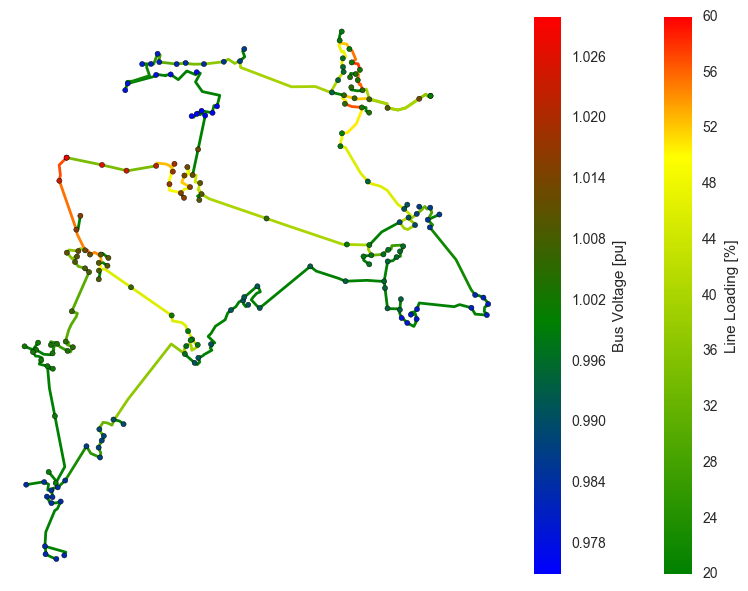

In [7]:
cmap_list=[(0.975, "blue"), (1.0, "green"), (1.03, "red")]
cmap, norm = plot.cmap_continous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=80, zorder=2, cmap=cmap, norm=norm)
plot.draw_collections([lc, bc], figsize=(8,6))

### Discrete Colormaps

Discrete colormaps can be used in the same way as continous colormaps using the cmap_voltage_discrete and cmap_loading_discrete functions. For discrete colormaps, each color has to be assigned a range instead of a center:

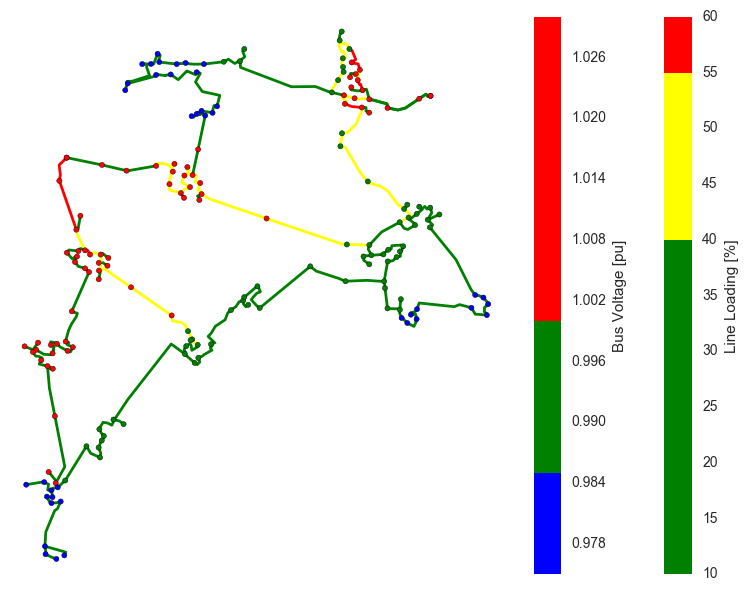

In [8]:
net = nw.mv_oberrhein()
pp.runpp(net)
cmap_list=[((0.975, 0.985), "blue"), ((0.985, 1.0), "green"), ((1.0, 1.03), "red")]
cmap, norm = plot.cmap_discrete(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=80, zorder=2, cmap=cmap, norm=norm)

cmap_list=[((10, 40), "green"), ((40, 55), "yellow"), ((55, 60), "red")]
cmap, norm = plot.cmap_discrete(cmap_list)
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2)
plot.draw_collections([lc, bc], figsize=(8,6))

## Custom Colormaps and Colorbars

The functions to create colormaps and norms are merely convenience functions. You can individually create any colormap you like and pass it to the create_collection functions.

For example, for the colorbar "PuBu_r" from matplotlib:

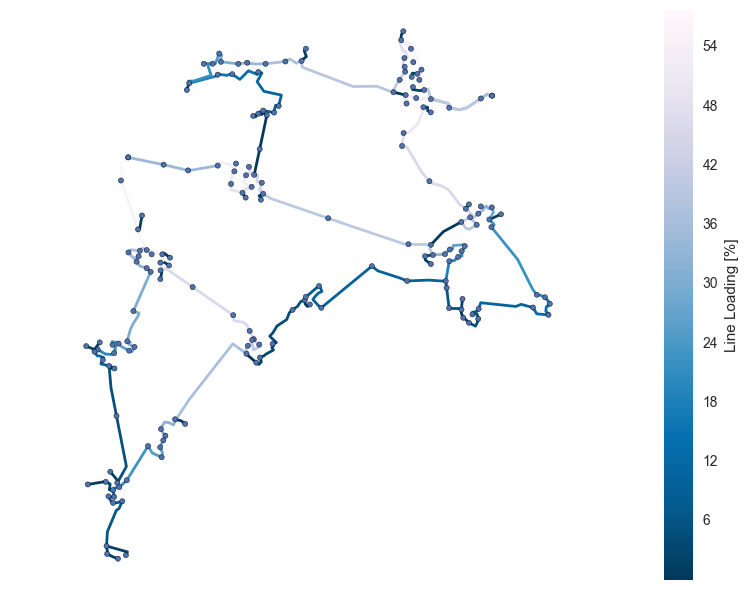

In [9]:
from matplotlib.pyplot import get_cmap
from matplotlib.colors import Normalize

cmap = get_cmap('PuBu_r')
lc = plot.create_line_collection(net, net.line.index, zorder=1, color="grey", linewidths=2,
                                     cmap=cmap)
bc = plot.create_bus_collection(net, net.bus.index, size=80, zorder=2)
plot.draw_collections([lc, bc], figsize=(8,6))

Plotting without a norm maps the colorbar to the range of the data points (here: line loadings). Normalizing to values between 20 and 100 yields:

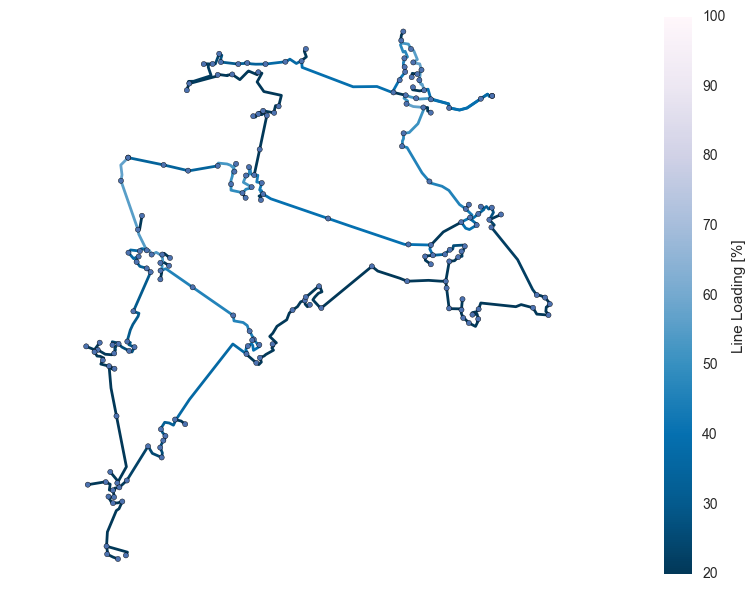

In [10]:
cmap = get_cmap('PuBu_r')
norm = Normalize(vmin=20, vmax=100)
lc = plot.create_line_collection(net, net.line.index, zorder=1, color="grey", linewidths=2,
                                     cmap=cmap, norm=norm)
bc = plot.create_bus_collection(net, net.bus.index, size=80, zorder=2)
plot.draw_collections([lc, bc], figsize=(8,6))

The colorbar can be customized by disabling the automatic plotting of the colorbar in draw_collections and plotting the colorbar directly with the desired parameters:

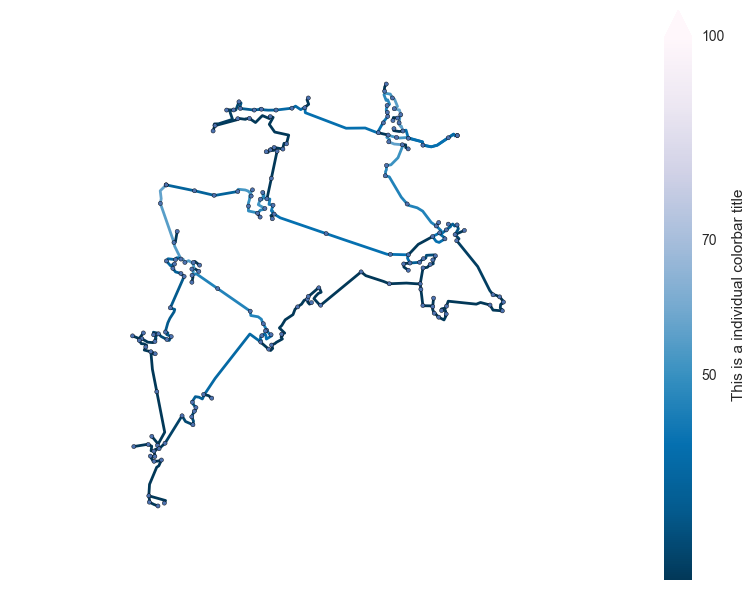

In [11]:
from matplotlib.pyplot import colorbar

plot.draw_collections([lc, bc], figsize=(8,6), plot_colorbars=False)
cbar = colorbar(lc, extend="max")
cbar.set_ticks([50, 70, 100])
cbar.ax.set_ylabel("This is a individual colorbar title")

## Direct Line Connections

Line collections are plotted with the geographical coordinates of the lines that are stored in net.line_geodata by default. You can also plot lines as direct connections between the buses, by calling the create_line_collection function with use_line_geodata=False:

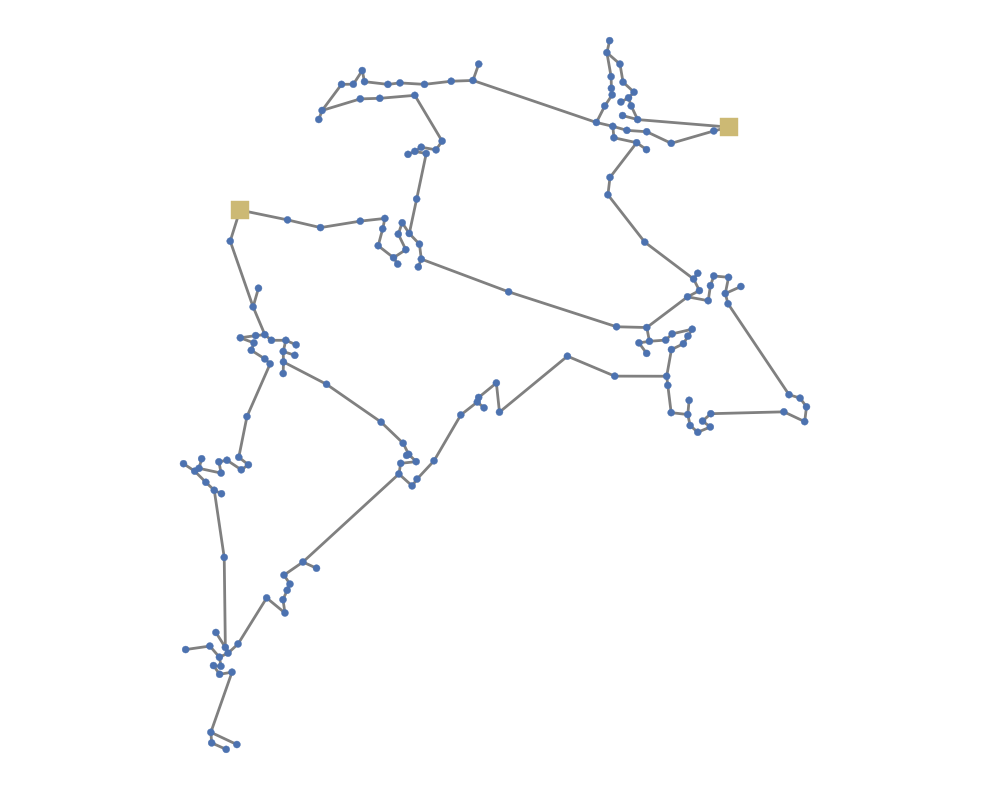

In [9]:
net = nw.mv_oberrhein()
bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=10)
lcd = plot.create_line_collection(net, net.line.index, use_line_geodata=False, color="grey", linewidths=2.)
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200,
                                              color=colors[4], zorder=11)
plot.draw_collections([lcd, bc, sc])

As a comparison, here are the lines with direct connections (solid) and the line trails from line_geodata (dashed):

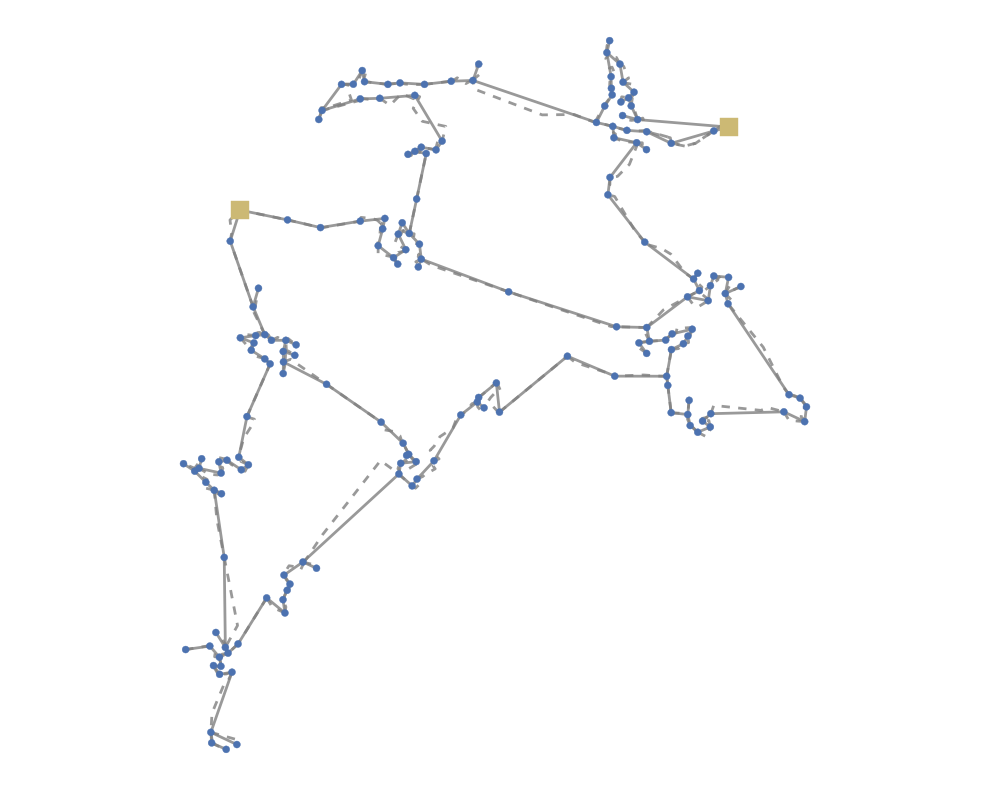

In [10]:
net = nw.mv_oberrhein()
bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=10)
lcd = plot.create_line_collection(net, lines=net.line.index, color="grey",alpha=0.8, linewidths=2., use_line_geodata=False)
lc = plot.create_line_collection(net, lines=net.line.index, color="grey",alpha=0.8, linestyles="dashed", linewidths=2.)
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200,
                                              color=colors[4], zorder=11)
plot.draw_collections([lc, lcd, bc, sc])

## Generic Coordinates

If you do not have geographic coordinates, you can create generic coordinates for plotting with the create_generic_coordinates function.

<div class="alert alert-warning">
You need to install the python-igraph package for this functionality: http://igraph.org/python/
<div/>

We delete the geocoordinates from the network and create generic ones:

In [11]:
net = nw.mv_oberrhein()
del net.bus_geodata #delete the geocoordinates
del net.line_geodata
plot.create_generic_coordinates(net, respect_switches=False) #create artificial coordinates with the igraph package

This pandapower network includes the following parameter tables:
   - ext_grid (2 elements)
   - bus_geodata (179 elements)
   - sgen (153 elements)
   - line (181 elements)
   - trafo (2 elements)
   - bus (179 elements)
   - switch (322 elements)
   - load (147 elements)
 and the following results tables:
   - res_sgen (153 elements)
   - res_trafo (2 elements)
   - res_bus (179 elements)
   - res_line (181 elements)
   - res_ext_grid (2 elements)
   - res_load (147 elements)

As you can see the table bus_geodata has been created and we can now plot as before. Since the function only creates bus geodata, we can only use the direct line plotting. Furthermore it creates a distance between high- and low voltage bus of a transformer, which is why we also need a transformer collection:

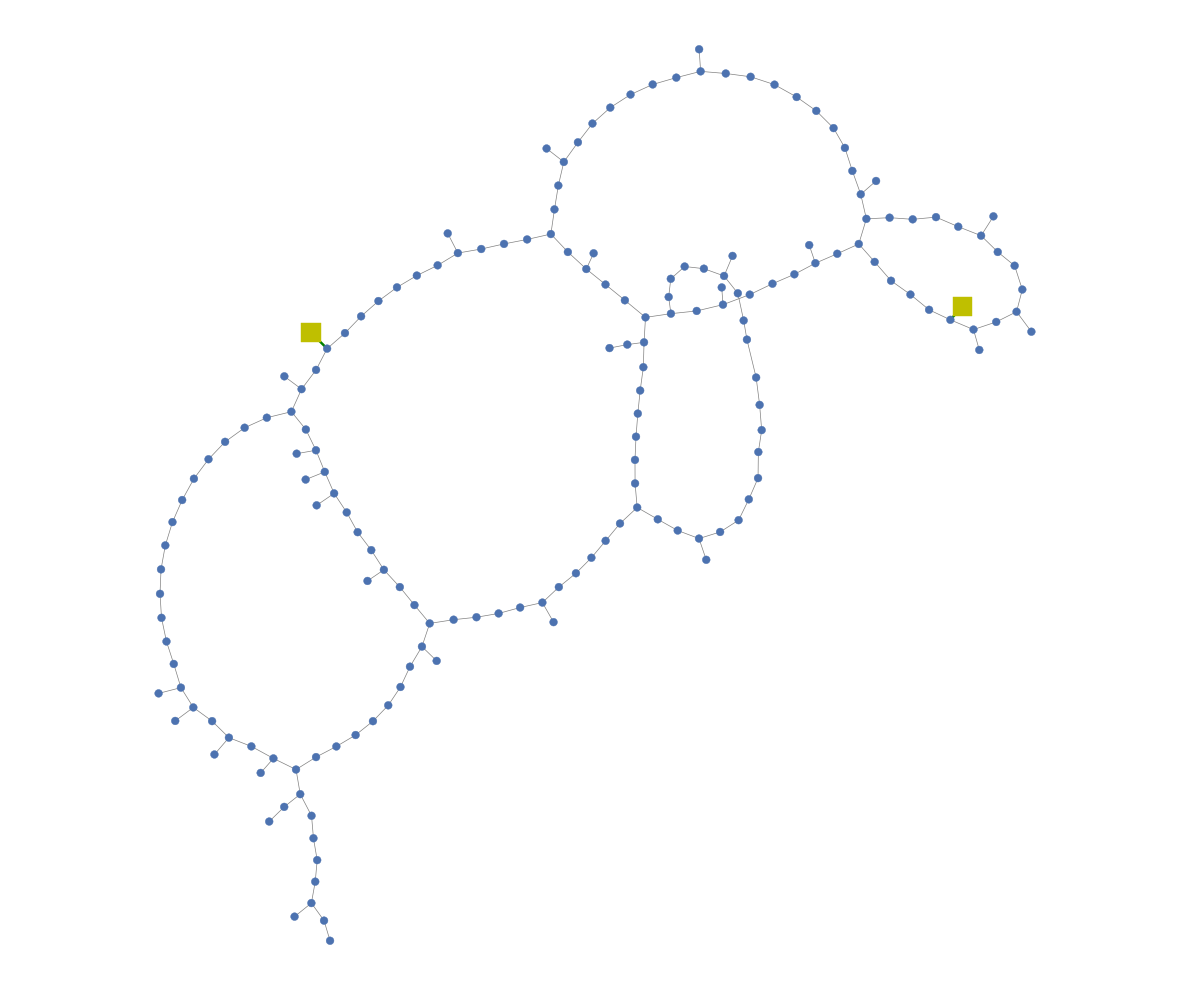

In [12]:
bc = plot.create_bus_collection(net, net.bus.index, size=.2, color=colors[0], zorder=10)
tc = plot.create_trafo_collection(net, net.trafo.index, color="g")
lcd = plot.create_line_collection(net, net.line.index, color="grey", linewidths=0.5, use_line_geodata=False)
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=.5, color="y", zorder=11)
plot.draw_collections([lcd, bc, tc, sc], figsize=(8,6))

The create_generic_coordinates function treats transformers as edges, which means the HV and LV side of the transformer are shown by seperate buses with a connection (green line).

If you do not want to plot the transformers you can use the fuse_geodata function. It fuses the geocoordinates of all buses that are geographically in one place (HV/LV bus of a transformer or buses and buses that are connected by a bu-bus switch):

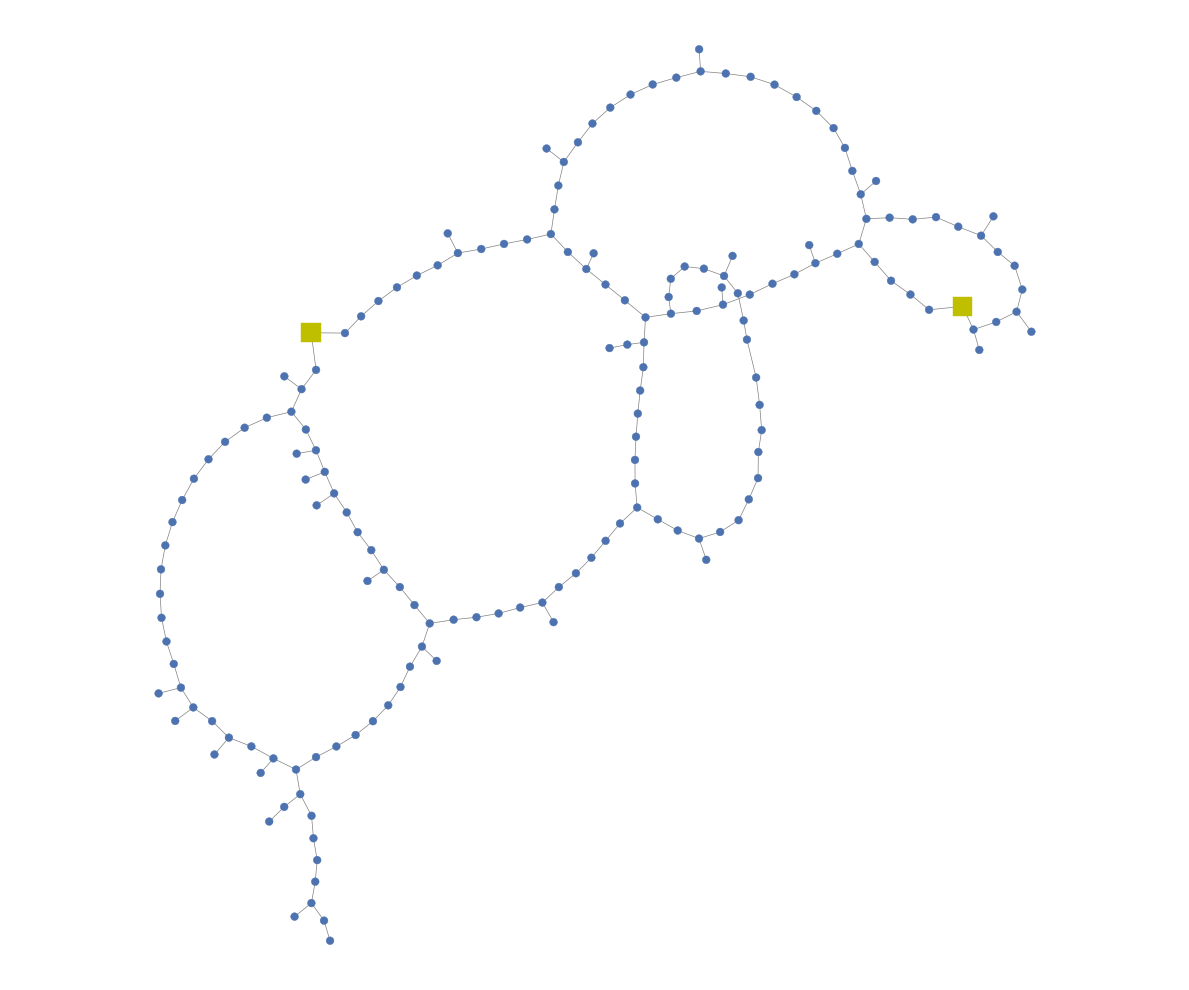

In [13]:
plot.fuse_geodata(net)
bc = plot.create_bus_collection(net, net.bus.index, size=.2, color=colors[0], zorder=10)
tc = plot.create_trafo_collection(net, net.trafo.index, color="g")
lcd = plot.create_line_collection(net, net.line.index, color="grey", linewidths=0.5, use_line_geodata=False)
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=.5, color="y", zorder=11)
plot.draw_collections([lcd, bc, tc, sc], figsize=(8,6))

## Plot Structural Plans

To plot a structural plan of the network instead of a geographical one, call the generic coordinates function with respect_switches=True.

In [14]:
net = nw.mv_oberrhein()
del net.bus_geodata #delete the geocoordinates
del net.line_geodata
plot.create_generic_coordinates(net, respect_switches=True) #create artificial coordinates with the igraph package

This pandapower network includes the following parameter tables:
   - ext_grid (2 elements)
   - bus_geodata (179 elements)
   - sgen (153 elements)
   - line (181 elements)
   - trafo (2 elements)
   - bus (179 elements)
   - switch (322 elements)
   - load (147 elements)
 and the following results tables:
   - res_sgen (153 elements)
   - res_trafo (2 elements)
   - res_bus (179 elements)
   - res_line (181 elements)
   - res_ext_grid (2 elements)
   - res_load (147 elements)

In that way, the algorithm seperates buses which are seperated by an open switch:

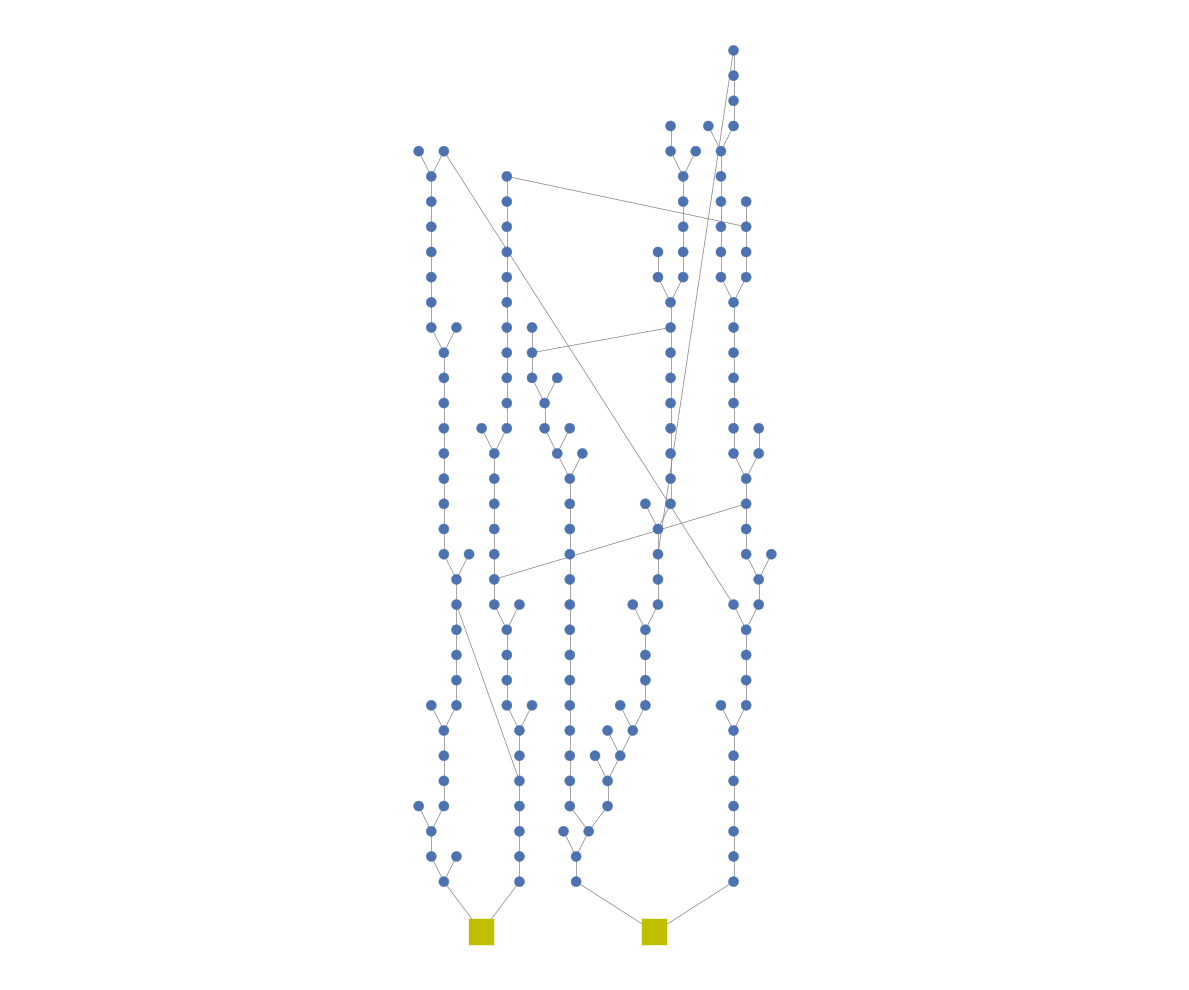

In [15]:
plot.fuse_geodata(net)
bc = plot.create_bus_collection(net, net.bus.index, size=.2, color=colors[0], zorder=10)
tc = plot.create_trafo_collection(net, net.trafo.index, color="g")
lcd = plot.create_line_collection(net, net.line.index, color="grey", linewidths=0.5, use_line_geodata=False)
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=.5, color="y", zorder=11)
plot.draw_collections([lcd, bc, tc, sc], figsize=(8,6))

For a clearer arrangement, it might be useful to only plot the lines without an open switch:

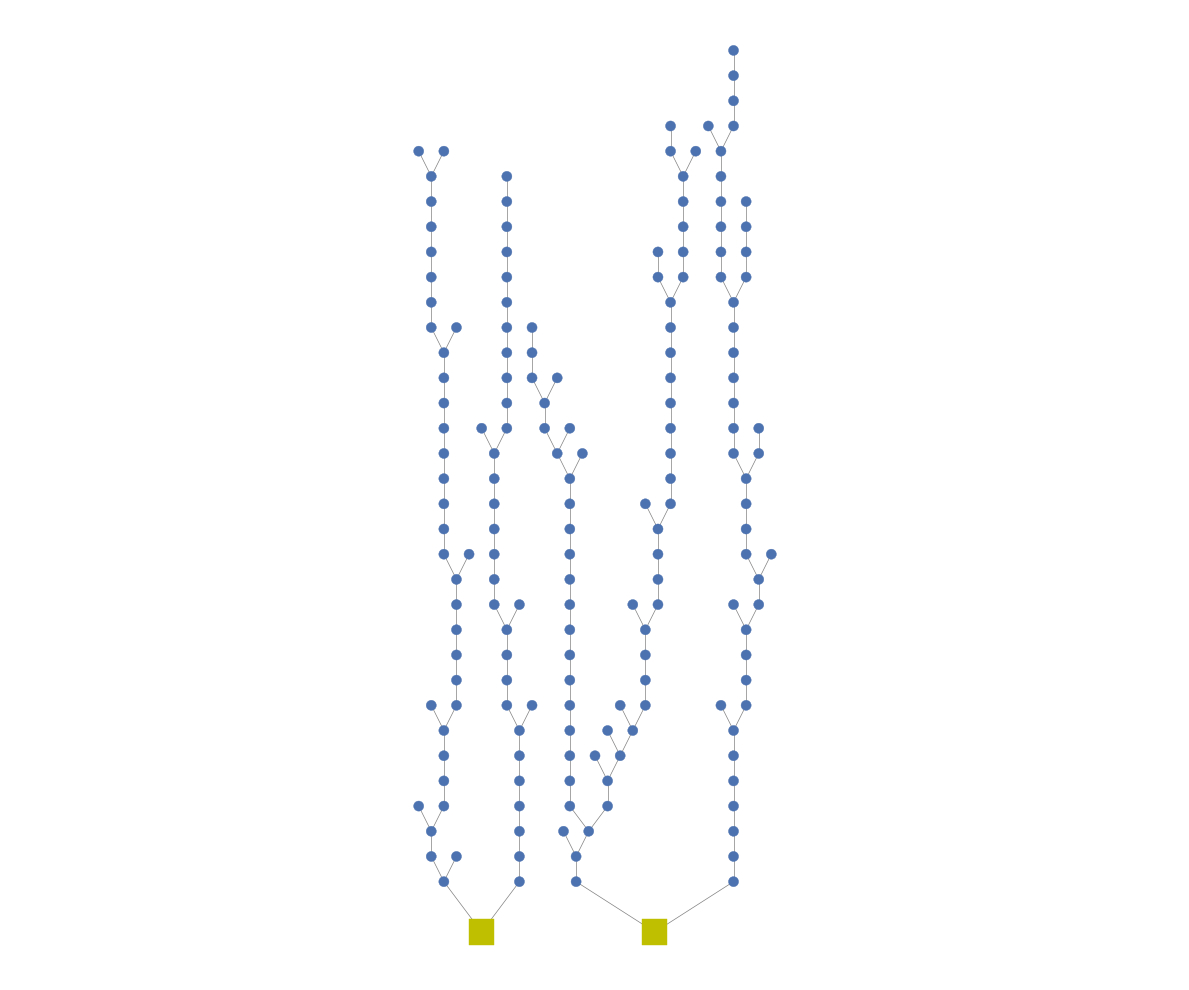

In [16]:
closed_lines = set(net.line.index) - set(net.switch[(net.switch.et=="l") & (net.switch.closed==False)].element.values)
lcd = plot.create_line_collection(net, closed_lines, color="grey", linewidths=0.5, use_line_geodata=False)
plot.draw_collections([lcd, bc, tc, sc], figsize=(8,6))